This script is used to plot and analyze DDM bias/adaptation parameters

Produces Figures 6a-d and the parameter fits for Table 4.

Also can be used to output the params_blockW_forR csv file, which is used by the bias_slope_differences.ipynb R notebook.

In [1]:
imatlab_export_fig('print-svg')
set(0,'defaultfigurecolor',[1 1 1])
set(groot,'DefaultAxesFontName','Arial')

% data files/dir
GFIT_DIR = '../FitGDDM/fits';
models_block = readtable('model_info_block.csv','ReadVariableNames',true,'Delimiter',',');

%for display
set(groot,'defaultBarFaceAlpha',0.54)
psych_leg={'low','neutral','high'};
psych_color={'b','k','r'};

# parameter descriptives

In [2]:
logistic = @(x) 1./(1+exp(-x));
logit = @(x) log(x./(1-x));

params_block = table();
for m=1:height(models_block)
    this_params = readtable(fullfile(GFIT_DIR,models_block.params{m}));
    this_params.model = repmat(models_block.name(m),height(this_params),1);
    this_params.block = repmat(models_block.title(m),height(this_params),1);
    this_params.hit_boundary = [];
    
    if strcmp(models_block.title(m),'priorOnly')
        %rename to match other models
        this_params.param(strcmp(this_params.param,'nondectime')) = ... 
            strrep(this_params.param(strcmp(this_params.param,'nondectime')),'nondectime','nondectime_No');
        %convert zs to logit scale to match other models but save original scale as nolog
        this_paramsnolog = this_params(startsWith(this_params.param,'z_'),:);
        this_paramsnolog.param = strcat(this_paramsnolog.param,'nolog');
        this_params.value(startsWith(this_params.param,'z_')) = ...
            logit(this_params.value(startsWith(this_params.param,'z_')));
        this_params = [this_params;this_paramsnolog];
            clear this_paramsnolog
    else
        %convert from logit to proprortion bound height [0,1]. Warning this IGNORES the intercept
        %then add the logistic scale fits to the end (probably unused)
        this_paramsnolog = this_params(startsWith(this_params.param,'z_'),:);
        this_paramsnolog.param = strcat(this_paramsnolog.param,'nolog');
        this_paramsnolog.value = logistic(this_paramsnolog.value);
        this_params = [this_params;this_paramsnolog];
        clear this_paramsnolog
        %flip taus
        %this_params.value(startsWith(this_params.param,'tau_')) = ...
        %    1./this_params.value(startsWith(this_params.param,'tau_'));
    end
    
    params_block = [params_block;this_params];
    
end
block_list = unique(params_block.block);
params_block.blocknum = zeros(height(params_block),1);
for b=1:length(block_list)
    switch block_list{b}
        case 'priorOnly'
            params_block.blocknum(strcmp(params_block.block,block_list{b})) = 1;
        case 'pretoneOnly'
            params_block.blocknum(strcmp(params_block.block,block_list{b})) = 2;
        case 'pretone_pLH'
            params_block.blocknum(strcmp(params_block.block,block_list{b})) = 3;
        case 'pretone5'
            params_block.blocknum(strcmp(params_block.block,block_list{b})) = 4;
        case {'pretone_pL','pretone_pH'}
            params_block.blocknum(strcmp(params_block.block,block_list{b})) = 5;
    end
end

%remove fixed params
params_block(strcmp(params_block.param,'noise'),:) = [];
params_block(strcmp(params_block.block,'pretone_pLH') & ...
    ismember(params_block.param,{'v_No','z_No','z_Nolog'}),:) = [];

params_block = sortrows(params_block,{'subject','blocknum','param'});

In [3]:
%Ns
block_list = unique(params_block.block);
for i=1:length(block_list)
    fprintf('%s N=%d\n\n',block_list{i},...
        length(unique(params_block.subject(strcmp(params_block.block,block_list{i})))));
end
fprintf('priorOnly-pretoneOnly N=%d',...
    length(unique(params_block.subject(ismember(params_block.block,{'priorOnly','pretoneOnly'})))))

pretone5 N=21

pretoneOnly N=45

pretone_pLH N=41

priorOnly N=49

priorOnly-pretoneOnly N=50

Note that these Ns may differ from other analyses due to exclusion criteria, missing data, etc.

### parameter tables (for Table 4)

In [4]:
params_block_ave = summary_stats(params_block,'value',{'param','blocknum','block'});

params_block_ave_print = sortrows(params_block_ave,{'blocknum','param'});
params_block_ave_print = ...
    params_block_ave_print(:,~ismember(params_block_ave_print.Properties.VariableNames,{'GroupCount','sem_value'}));
params_block_ave_print.Properties.VariableNames({'mean_value','std_value'}) = {'mean','sd'};
params_block_ave_print(endsWith(params_block_ave_print.param,'nolog'),:) = [];

print_bs = [1:4];
print_orders = {{'v_SNR','B','t','nondectime_No','umixturecoef','v_Low','v_No','v_High','z_Low','z_No','z_High'},...
    {'v_SNR','B','t','nondectime_No','nondectime_Bias','umixturecoef',...
        'v_No','v_Bias','tau_Bias','wa_Low','wa_High','tau_Adapt','z_No','z_Bias'},...
    {'v_SNR','B','t','nondectime_No','nondectime_Bias','umixturecoef',...
        'v_Low','v_High','v_Bias','tau_Bias','wa_Low','wa_High','tau_Adapt','z_Low','z_High','z_Bias'},...
    {'v_SNR','B','t','nondectime_No','nondectime_Bias','umixturecoef',...
        'v_Low','v_No','v_High','v_Bias','tau_Bias','wa_Low','wa_High','tau_Adapt','z_Low','z_No','z_High','z_Bias'}};

for b=1:length(print_bs)
    this_pprint = params_block_ave_print(params_block_ave_print.blocknum==print_bs(b),:);

    this_order = print_orders{b};

    [immyfoo,orderfoo] = ismember(this_order,this_pprint.param);
    assert(all(immyfoo))
    this_pprint = this_pprint(orderfoo,:)
    writetable(this_pprint,sprintf('%s_param_ave.csv',this_pprint.block{1}))
end


this_pprint =

  11x5 table

          param          blocknum        block          mean         sd   
    _________________    ________    _____________    ________    ________

    {'v_SNR'        }       1        {'priorOnly'}      6.5098      3.3596
    {'B'            }       1        {'priorOnly'}     0.92372     0.25704
    {'t'            }       1        {'priorOnly'}     0.91842     0.47697
    {'nondectime_No'}       1        {'priorOnly'}      0.2748    0.078501
    {'umixturecoef' }       1        {'priorOnly'}    0.022812    0.014343
    {'v_Low'        }       1        {'priorOnly'}    -0.82577     0.78539
    {'v_No'         }       1        {'priorOnly'}    0.065458     0.41159
    {'v_High'       }       1        {'priorOnly'}     0.67416     0.71093
    {'z_Low'        }       1        {'priorOnly'}    -0.19866     0.31121
    {'z_No'         }       1        {'priorOnly'}    0.055847       0.224
    {'z_High'       }       1        {'priorOnly'}     0.39277     0.

### consistency of fit params

In [5]:
%FINAL 
%can use this for any DDM tests of "consistency of params" (e.g., adapt weights consistently negative) 

param_test_list = {{'v_Low','v_High'},{'z_Low','z_High'},{'v_Bias'},{'wa_Low','wa_High'},{'z_Bias'}};
param_tests = [];
for b=1:2%length(block_list)
    for i=1:length(param_test_list)
        this_paramset = param_test_list{i};
        this_params = params_block(ismember(params_block.param,this_paramset) & ...
            params_block.blocknum==b,:);
        paramset_table = [];
        if ~isempty(this_params)
            for j=1:length(this_paramset)
                this_block = unique(this_params.block(this_params.blocknum==b));%wow this is hacky
                %disp(this_block{1}) 
                %disp(this_paramset{j})
                [h p ci stats] = ttest(this_params.value(strcmp(this_params.param,this_paramset{j})));
                this_ttable = table(this_block,this_paramset(j),stats.tstat,stats.df,p,...
                    'VariableNames',{'block','param','t','df','p'});
                paramset_table = [paramset_table;this_ttable];
            end
            paramset_table.pcorr = pval_adjust(paramset_table.p,'holm');
            param_tests = [param_tests;paramset_table];
        end
    end
end
param_tests.hcorr = double(param_tests.pcorr < .05);
param_tests


param_tests =

  8x7 table

         block            param          t       df        p           pcorr       hcorr
    _______________    ___________    _______    __    __________    __________    _____

    {'priorOnly'  }    {'v_Low'  }    -7.3599    48    2.0685e-09    4.1369e-09      1  
    {'priorOnly'  }    {'v_High' }      6.638    48    2.6416e-08    2.6416e-08      1  
    {'priorOnly'  }    {'z_Low'  }    -4.4685    48    4.7938e-05    4.7938e-05      1  
    {'priorOnly'  }    {'z_High' }     8.8307    48    1.2604e-11    2.5208e-11      1  
    {'pretoneOnly'}    {'v_Bias' }      7.729    44    9.9135e-10    9.9135e-10      1  
    {'pretoneOnly'}    {'wa_Low' }    -8.5764    44    6.0915e-11    1.2183e-10      1  
    {'pretoneOnly'}    {'wa_High'}    -5.3719    44    2.7993e-06    2.7993e-06      1  
    {'pretoneOnly'}    {'z_Bias' }    -3.6431    44     0.0007068     0.0007068      1  



# Bias Tradeoffs

In [6]:
%compute differences of High/Low as proxy for overall bias.

params_blockW = unstack(params_block(:,{'subject','block','blocknum','param','value'}),...
    'value','param');
    
params_blockW.v_diff = params_blockW.v_High - params_blockW.v_Low;
params_blockW.z_diff = params_blockW.z_High - params_blockW.z_Low;

params_blockW.v_BiasHH = params_blockW.v_Bias.*pt_exp(params_blockW.tau_Bias,[1 1]);
params_blockW.v_BiasLL = params_blockW.v_Bias.*pt_exp(params_blockW.tau_Bias,[-1 -1]);
params_blockW.v_Biasdiff = params_blockW.v_BiasHH - params_blockW.v_BiasLL;

params_blockW.z_BiasHH = params_blockW.z_Bias.*pt_exp(params_blockW.tau_Bias,[1 1]);
params_blockW.z_BiasLL = params_blockW.z_Bias.*pt_exp(params_blockW.tau_Bias,[-1 -1]);
params_blockW.z_Biasdiff = params_blockW.z_BiasHH - params_blockW.z_BiasLL;

assert(isequal(params_blockW.v_Biasdiff(params_blockW.blocknum==2),...
    params_blockW.v_BiasHH(params_blockW.blocknum==2)-...
    params_blockW.v_BiasLL(params_blockW.blocknum==2)))
assert(isequal(params_blockW.z_Biasdiff(params_blockW.blocknum==2),...
    params_blockW.z_BiasHH(params_blockW.blocknum==2)-...
    params_blockW.z_BiasLL(params_blockW.blocknum==2)))

In [7]:
%if true, output for use in bias_slope_differences.ipynb
if false
    writetable(params_blockW,['params_blockW_forR_' date() '.csv'])
end

## Do start shift and evidence bias trade-off for prior cues?


zv_prior =

  8x5 table

         block           prior         r            p           pcorr   
    _______________    _________    ________    __________    __________

    {'priorOnly'  }    {'_Low' }    -0.49449     0.0003619     0.0003619
    {'priorOnly'  }    {'_No'  }    -0.71837     3.576e-08    1.0728e-07
    {'priorOnly'  }    {'_High'}    -0.61857     3.698e-06    7.3959e-06
    {'pretone_pLH'}    {'_Low' }    -0.48258     0.0015807     0.0031615
    {'pretone_pLH'}    {'_High'}    -0.43815     0.0044983     0.0044983
    {'pretone5'   }    {'_Low' }    -0.69351    0.00068942     0.0013788
    {'pretone5'   }    {'_No'  }    -0.77143    6.3158e-05    0.00018947
    {'pretone5'   }    {'_High'}    -0.65584     0.0016277     0.0016277



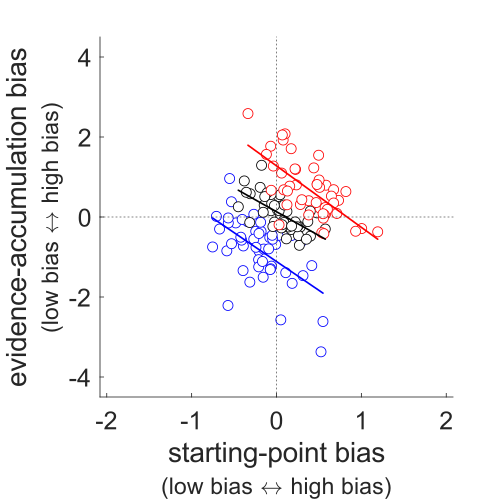

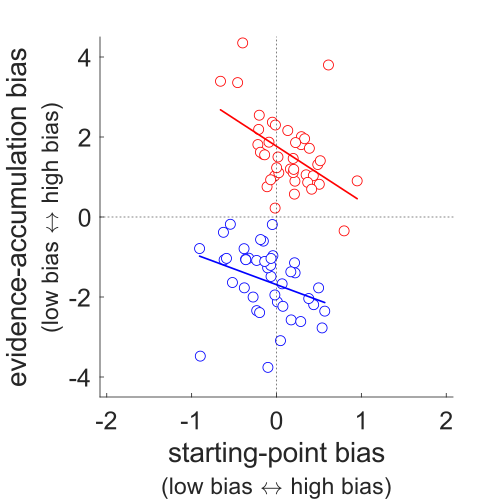

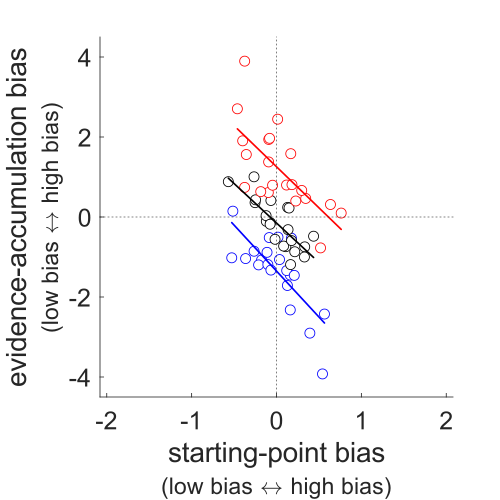

In [8]:
prior_blocks = {'priorOnly','pretone_pLH','pretone5'}; 
prior_suffix = {'_Low','_No','_High'};


this_figdim = [0 0 400 400];
set(groot,'DefaultAxesFontSize',15)
set(groot,'DefaultLineLineWidth',1)
set(groot,'DefaultScatterMarkerFaceColor',[1 1 1])

zv_prior = [];

for b=1:length(prior_blocks)
    this_param_subj = params_blockW(strcmp(params_blockW.block,prior_blocks{b}),:);

    figure('Position',this_figdim);
    hold on;
    xline(0,':');
    yline(0,':');
    for p=1:length(prior_suffix)
        x=this_param_subj.(['z' prior_suffix{p}]);
        y=this_param_subj.(['v' prior_suffix{p}]);
        if length(x) > 0
            scatter(x,y,psych_color{p});
        end
    end
    ylabel({'evidence-accumulation bias','\fontsize{14}(low bias \leftrightarrow high bias)'});
    xlabel({'starting-point bias','\fontsize{14}(low bias \leftrightarrow high bias)'});
    
    %separate loop so as not to mess up legend FYI
    for p=1:length(prior_suffix)
        x=this_param_subj.(['z' prior_suffix{p}]);
        y=this_param_subj.(['v' prior_suffix{p}]);
        if length(x) > 0 && ~all(isnan(x))
            %disp([prior_blocks{b} prior_suffix{p}]);
            [r pval] = corr(x,y,'type','Spearman');
            if pval<.05
                c = polyfit(x,y,1);
                y_est = polyval(c,x);
                plot(x,y_est,psych_color{p})
            end
            
            %collect correlations/pvals and correct (holm)
            this_zv_prior = table(prior_blocks(b),prior_suffix(p),r,pval,...
                'VariableNames',{'block','prior','r','p'});
            zv_prior = [zv_prior;this_zv_prior];
            clear this_zv_prior
        end
    end

    xlim([-2.0794,2.0794]); 
    if ismember(prior_blocks{b},{'priorOnly'})
        ylim([-4.5 4.5])
    else
        ylim([-4.5 4.5])
    end
    
      
end

set(groot,'DefaultAxesFontSize','factory')
set(groot,'DefaultLineLineWidth','factory')
set(groot,'DefaultScatterMarkerFaceColor','factory')

zv_prior.pcorr=nan(height(zv_prior),1);
for b=1:length(prior_blocks)
    zv_prior.pcorr(strcmp(zv_prior.block,prior_blocks{b})) = ...
        pval_adjust(zv_prior.p(strcmp(zv_prior.block,prior_blocks{b})),'holm');
end
zv_prior

## Do start shift and evidence bias trade-off for pretones?

pretoneOnly

r =

   -0.1993


pval =

    0.1887

pretone_pLH

r =

   -0.2131


pval =

    0.1805

pretone5

r =

   -0.4143


pval =

    0.0631



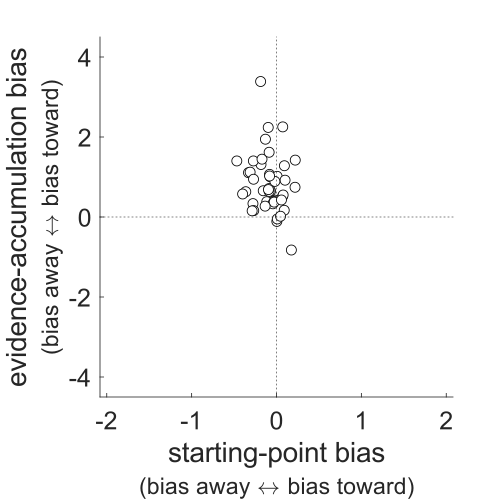

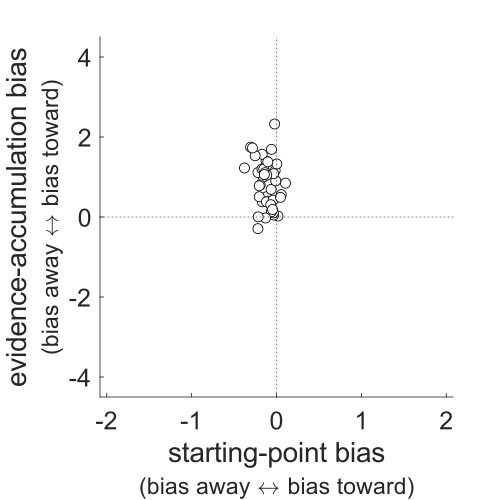

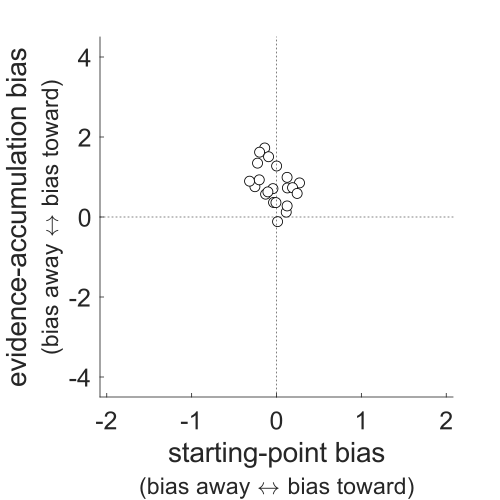

In [9]:
pt_blocks = {'pretoneOnly','pretone_pLH','pretone5'}; 

this_figdim = [0 0 400 400];
set(groot,'DefaultAxesFontSize',15)
set(groot,'DefaultLineLineWidth',1)
set(groot,'DefaultScatterMarkerFaceColor',[1 1 1])

for b=1:length(pt_blocks)
    this_param_subj = params_blockW(strcmp(params_blockW.block,pt_blocks{b}),:);

    figure('Position',this_figdim);
    hold on;
    xline(0,':');
    yline(0,':');

    x=this_param_subj.z_Bias;
    y=this_param_subj.v_Bias;
    if length(x) > 0 && ~all(isnan(x))
        scatter(x,y,'k');
        disp(pt_blocks{b})
        [r pval] = corr(x,y,'type','Spearman')
        if pval<.05
            c = polyfit(x,y,1);
            y_est = polyval(c,x);
            plot(x,y_est,'k')
        end
    end

    ylabel({'evidence-accumulation bias','\fontsize{14}(bias away \leftrightarrow bias toward)'});
    xlabel({'starting-point bias','\fontsize{14}(bias away \leftrightarrow bias toward)'});

    xlim([-2.0794,2.0794]); 
    if ismember(prior_blocks{b},{'priorOnly'})
        ylim([-4.5 4.5])
    else
        ylim([-4.5 4.5])
    end
end

set(groot,'DefaultAxesFontSize','factory')
set(groot,'DefaultLineLineWidth','factory')
set(groot,'DefaultScatterMarkerFaceColor','factory')

# Are prior and pretone biases related (correlated)?

## priorOnly vs. pretoneOnly

v_diff-v_Bias

r =

    0.1694


p =

    0.2706

z_diff-z_Bias

r =

   -0.1159


p =

    0.4526



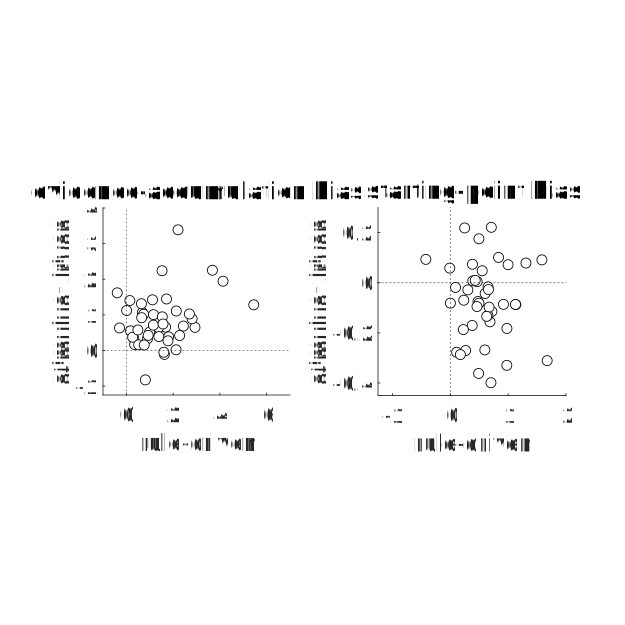

In [10]:
%Are prior and pretone biases related?
this_figdim = [0 0 500 500];
set(groot,'DefaultAxesFontSize',15)
set(groot,'DefaultLineLineWidth',1)
set(groot,'DefaultScatterMarkerFaceColor',[1 1 1])

x_vars = {'v_diff','z_diff'}; 
y_vars = {'v_Bias','z_Bias'}; 
xv_labels = {'rule-driven','rule-driven'}; 
yv_labels = {'stimulus-driven','stimulus-driven'}; 
v_titles = {'evidence-accumulation bias','starting-point bias'};
v_xlims = {[-1 7],[-1.25,2]};
v_ylims = {[-1.25 4],[-.45 .3]};

this_param_subjW = params_blockW(ismember(params_blockW.block,{'priorOnly','pretoneOnly'}),:);
this_valid_S = intersect(this_param_subjW.subject(strcmp(this_param_subjW.block,'priorOnly')),...
    this_param_subjW.subject(strcmp(this_param_subjW.block,'pretoneOnly')));
this_param_subjW  = this_param_subjW(ismember(this_param_subjW.subject,this_valid_S),:);

figure('Position',this_figdim);
for j=1:length(y_vars)
    subplot(1,2,j);
    hold on;
    xline(0,':');
    yline(0,':');
    x = this_param_subjW{strcmp(this_param_subjW.block,'priorOnly'),x_vars{j}};
    y = this_param_subjW{strcmp(this_param_subjW.block,'pretoneOnly'),y_vars{j}};
    fprintf('%s-%s\n',x_vars{j},y_vars{j})
    [r p]=corr(x,y,'type','Spearman')
    scatter(x,y,'k')
    if p<.05
        c = polyfit(x,y,1);
        y_est = polyval(c,x);
        plot(x,y_est,'-k')
    end

    xlabel(xv_labels{j},'Interpreter','tex');
    ylabel(yv_labels{j},'Interpreter','tex');
    title(v_titles{j})
    xlim(v_xlims{j})
    ylim(v_ylims{j})
    axis square

end

set(groot,'DefaultAxesFontSize','factory')
set(groot,'DefaultLineLineWidth','factory')
set(groot,'DefaultScatterMarkerFaceColor','factory')

### priorOnly vs. pretoneOnly evidence biases for evidence only pretone model (m13int)

Still not correlated!


r =

    0.2242


p =

    0.1431



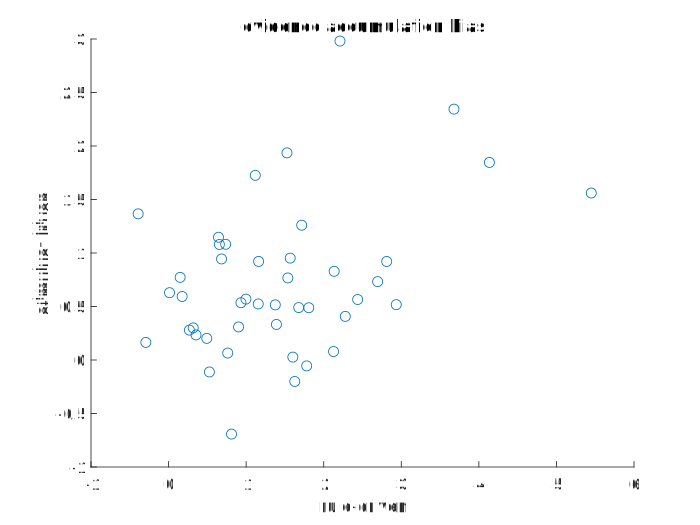

In [11]:
models_pt = readtable('model_info_pretone.csv','Delimiter',',');
m13_params = readtable(fullfile(GFIT_DIR,models_pt.params{startsWith(models_pt.name,'m13')}));
m13_paramsW = unstack(m13_params(:,{'subject','param','value'}),...
    'value','param');
m13_param_comp = innerjoin(m13_paramsW(:,{'subject','v_Bias'}),...
    params_blockW(strcmp(params_blockW.block,'priorOnly'),:),'Keys','subject','RightVariables','v_diff');
figure();scatter(m13_param_comp.v_diff,m13_param_comp.v_Bias)
title('evidence accumulation bias')
xlabel('rule-driven')
ylabel('stimulus-driven')
[r p] = corr(m13_param_comp.v_diff,m13_param_comp.v_Bias,'type','Spearman')

## Prior bias vs. pt bias w/in mixed blocks

pretone_pLH
v_diff-v_Bias

r =

    0.0481


p =

    0.7647

z_diff-z_Bias

r =

    0.2918


p =

    0.0645

pretone5
v_diff-v_Bias

r =

   -0.2727


p =

    0.2307

z_diff-z_Bias

r =

   -0.0597


p =

    0.7973



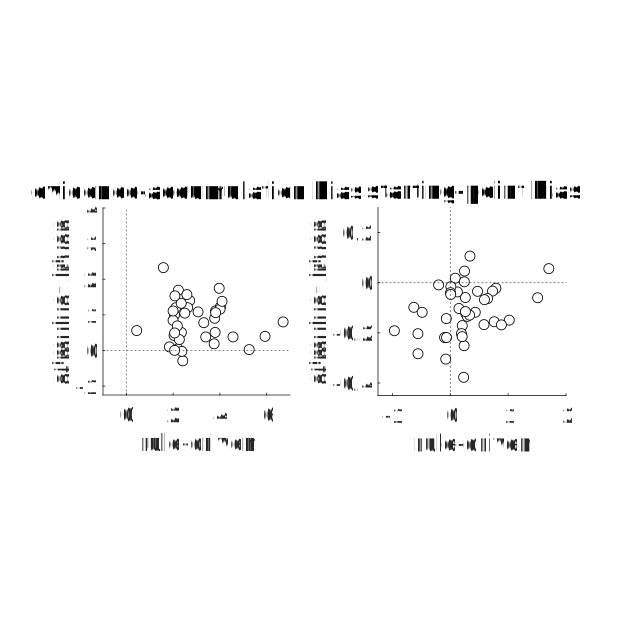

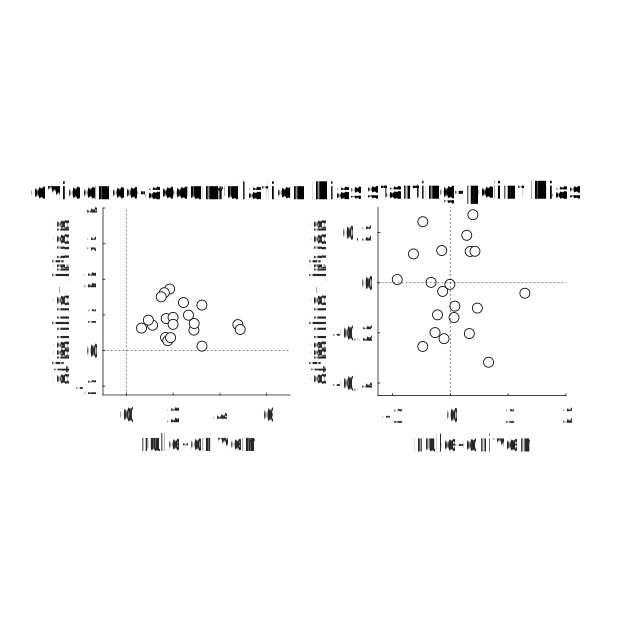

In [12]:
this_figdim = [0 0 500 500];
%this_subplot = @(m,n,p) subtightplot(m,n,p,.1,[.16,.1],[0.12 0.05]);
set(groot,'DefaultAxesFontSize',15)
set(groot,'DefaultLineLineWidth',1)
set(groot,'DefaultScatterMarkerFaceColor',[1 1 1])

ptprior_blocks = {'pretone_pLH','pretone5'};
v_xlims = {[-1 7],[-1.25,2]};
v_ylims = {[-1.25 4],[-.45 .3]};

for i=1:length(ptprior_blocks)
    this_param_subjW = params_blockW(strcmp(params_blockW.block,ptprior_blocks{i}),:);
    figure('Position',this_figdim);
    disp(ptprior_blocks{i})
    for j=1:length(y_vars)
        subplot(1,2,j);
        hold on;
        xline(0,':');
        yline(0,':');
        x = this_param_subjW.(x_vars{j});
        y = this_param_subjW.(y_vars{j});
        fprintf('%s-%s\n',x_vars{j},y_vars{j})
        [r p]=corr(x,y,'type','Spearman')
        scatter(x,y,'k')
        if p<.05
            c = polyfit(x,y,1);
            y_est = polyval(c,x);
            plot(x,y_est,'-k')
        end
        xlabel(xv_labels{j},'Interpreter','tex');
        ylabel(yv_labels{j},'Interpreter','tex');
        title(v_titles{j})
        xlim(v_xlims{j})
        ylim(v_ylims{j})
        axis square
    end
end


set(groot,'DefaultAxesFontSize','factory')
set(groot,'DefaultLineLineWidth','factory')
set(groot,'DefaultScatterMarkerFaceColor','factory')